In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get -qq install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = fontprop.get_name()
plt.rcParams["axes.unicode_minus"] = False

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import seaborn as sns
import numpy as np



/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [3]:
# parquet -> 대용량 데이터셋을 다루기 위한 확장자.
#csv -> 24만건 => 1.신용정보, .... 8.
#열 갯수 -> 700

In [4]:
train_path = "/content/drive/MyDrive/card_train.csv"
test_path = "/content/drive/MyDrive/card_test.csv"

In [5]:
train_df = pd.read_csv(train_path, encoding = 'utf-8-sig')

## 키워드별 Feature Importance 분석

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16467
[LightGBM] [Info] Number of data points in the train set: 56448, number of used features: 140
[LightGBM] [Info] Start training from score -7.850033
[LightGBM] [Info] Start training from score -9.842463
[LightGBM] [Info] Start training from score -2.933708
[LightGBM] [Info] Start training from score -1.927236
[LightGBM] [Info] Start training from score -0.222134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


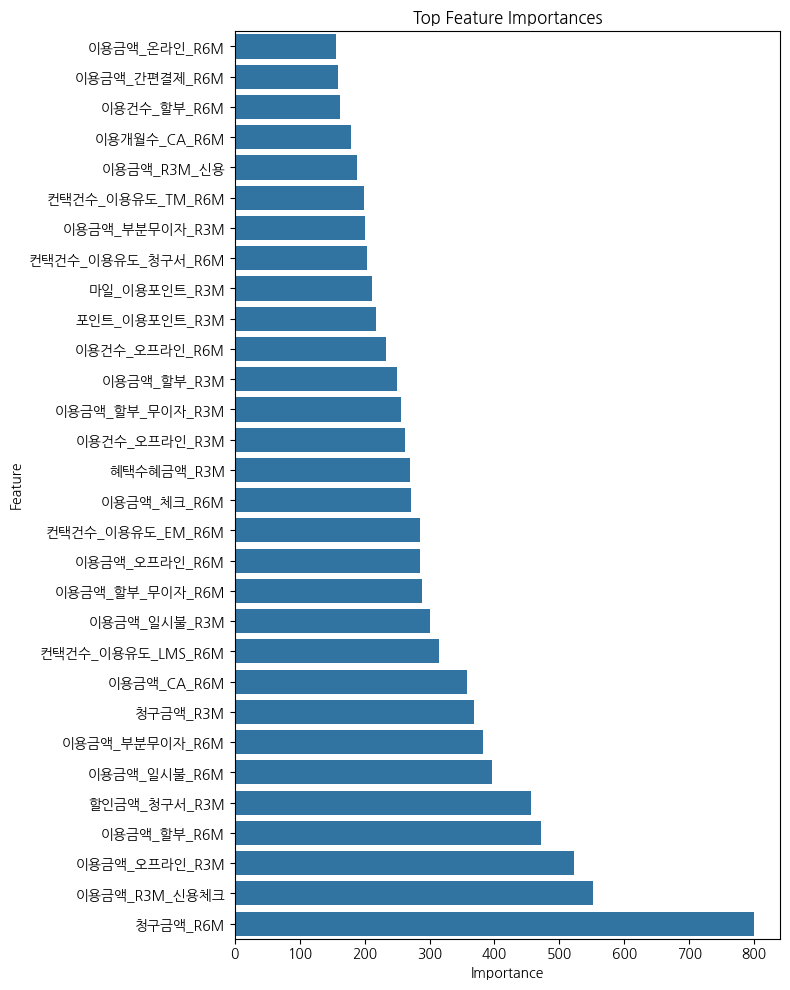

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np


# ------------------------------------------------


# 1. Load dataset
train_df = pd.read_csv(train_path, encoding = 'utf-8-sig')
y = train_df["Segment"]
X_full = train_df.drop(columns=["ID", "Unnamed: 0.1", "Segment.1", "Segment"], errors="ignore")

# 2. Feature selection by keyword + optional time_filters
def select_features_by_keywords(df, keywords, time_filters=None):
    if time_filters and len(time_filters) > 0:
        return df[[col for col in df.columns if any(k in col for k in keywords) and any(t in col for t in time_filters)]]
    else:
        return df[[col for col in df.columns if any(k in col for k in keywords)]]

# 3. Train & evaluate
def train_model_with_keywords(X, y):
    X = X.fillna("missing")
    for col in X.select_dtypes(include="object").columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred, average="macro")
    return model, score

# 4. Importance plot
def plot_feature_importance(model, feature_names, top_n=30):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 10))
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
    plt.title("Top Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 5. 실행: 키워드와 시간 필터 조건 지정 ----------------------------------------------------
keywords = ["이용", "금액", "연체"]
time_filters = ["R3M", "R6M"]  # []로 두면 기간 조건 X

X_selected = select_features_by_keywords(X_full, keywords, time_filters=time_filters)
model, score = train_model_with_keywords(X_selected, y)
print(f"Macro F1 score: {score:.4f}")
plot_feature_importance(model, X_selected.columns)


## 전체 Feature Importance 상위 50개 분석

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.895770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81396
[LightGBM] [Info] Number of data points in the train set: 56448, number of used features: 690
[LightGBM] [Info] Start training from score -7.850033
[LightGBM] [Info] Start training from score -9.842463
[LightGBM] [Info] Start training from score -2.933708
[LightGBM] [Info] Start training from score -1.927236
[LightGBM] [Info] Start training from score -0.222134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,feature,importance
0,이용금액_체크_R12M,502
1,정상청구원금_B5M,412
2,이용금액_일시불_R12M,350
3,월상환론한도금액,332
4,입회경과개월수_신용,272
5,입회일자_신용,215
6,최대이용금액_일시불_R12M,202
7,최대이용금액_체크_R12M,163
8,연속유실적개월수_기본_24M_카드,150
9,이용금액_할부_R12M,147


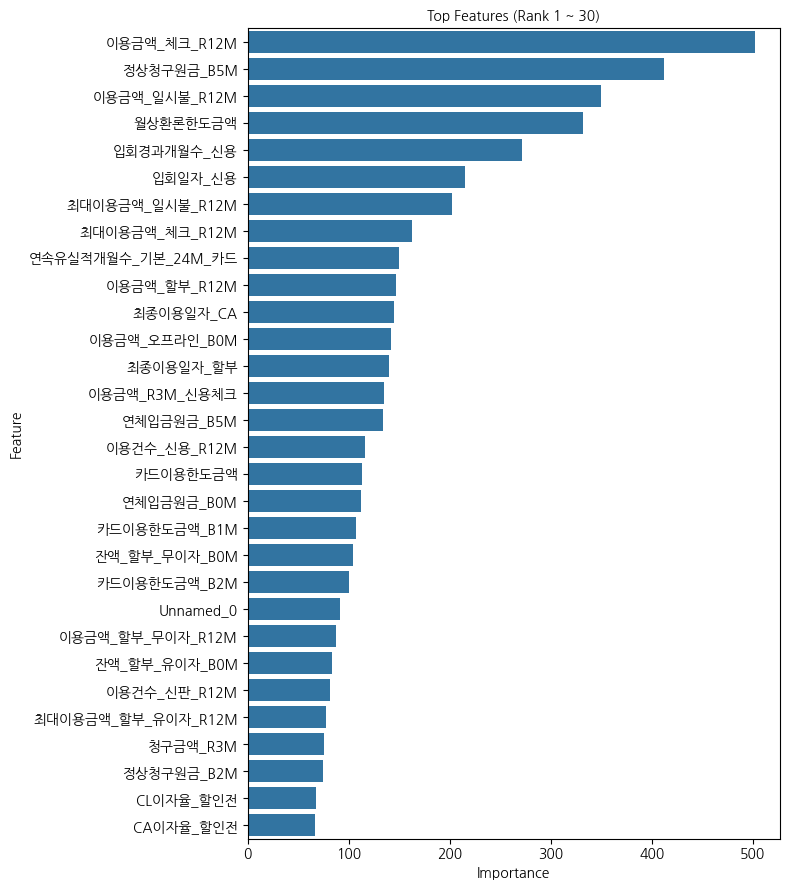

In [7]:
# 패키지 설치
!pip install lightgbm -q
!apt-get -qq install -y fonts-nanum

# 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import re

# 한글 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = fontprop.get_name()
plt.rcParams["axes.unicode_minus"] = False

# 데이터 불러오기
train_df = pd.read_csv("/content/drive/MyDrive/card_train.csv")
y = train_df["Segment"]
X_full = train_df.drop(columns=["ID", "Unnamed: 0.1", "Segment.1", "Segment"], errors="ignore")

# Function to sanitize column names
def sanitize_column_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = re.sub(r'[^\w_]+', '_', col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X_full = sanitize_column_names(X_full)

# 전체 피처에서 중요도 기반 정렬된 feature 반환
def get_top_features(X, y, top_n=None):
    X = X.fillna("missing")
    for col in X.select_dtypes(include="object").columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    importances = model.feature_importances_

    # top_n이 None이면 전체 사용
    if top_n is None:
        top_n = len(X.columns)
    top_indices = np.argsort(importances)[-top_n:]
    return X.iloc[:, top_indices], y, X.columns[top_indices]

# 모델 학습 및 평가
def train_model(X, y):
    X = X.fillna("missing")
    for col in X.select_dtypes(include="object").columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred, average="macro")
    return model, score

# 상태 기억형 섹터 기반 30개 단위 출력 함수
current_feature_index = 0

def show_next_30_features(model, feature_names, chunk_size=30):
    global current_feature_index
    importances = model.feature_importances_
    df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False).reset_index(drop=True)

    start = current_feature_index
    end = min(start + chunk_size, len(df))

    if start >= len(df):
        print("모든 피처를 다 출력했습니다.")
        return

    chunk = df.iloc[start:end]

    print(f"\nFeature Importance (Rank {start+1} ~ {end})")
    display(chunk)

    plt.figure(figsize=(8, max(6, chunk_size * 0.3)))
    sns.barplot(x="importance", y="feature", data=chunk)
    plt.title(f"Top Features (Rank {start+1} ~ {end})", fontproperties=fontprop)
    plt.xlabel("Importance", fontproperties=fontprop)
    plt.ylabel("Feature", fontproperties=fontprop)
    plt.tight_layout()
    plt.show()

    current_feature_index += chunk_size

# 실행
X_all, y, all_columns = get_top_features(X_full, y, top_n=None)
model_all, score_all = train_model(X_all, y)
print(f"Macro F1 score with ALL features: {score_all:.4f}")

# 30개씩 순차 출력
show_next_30_features(model_all, all_columns)  # 첫 호출



Feature Importance (Rank 31 ~ 60)


,feature,importance
30,가맹점매출금액_B2M,67
31,증감율_이용금액_신판_분기,67
32,변동률_잔액_B1M,67
33,월중평잔_할부,67
34,증감율_이용금액_일시불_분기,66
35,RV현금서비스이자율_할인전,66
36,일시상환론한도금액,66
37,정상청구원금_B0M,65
38,최종이용일자_신판,65
39,최대이용금액_CA_R12M,65


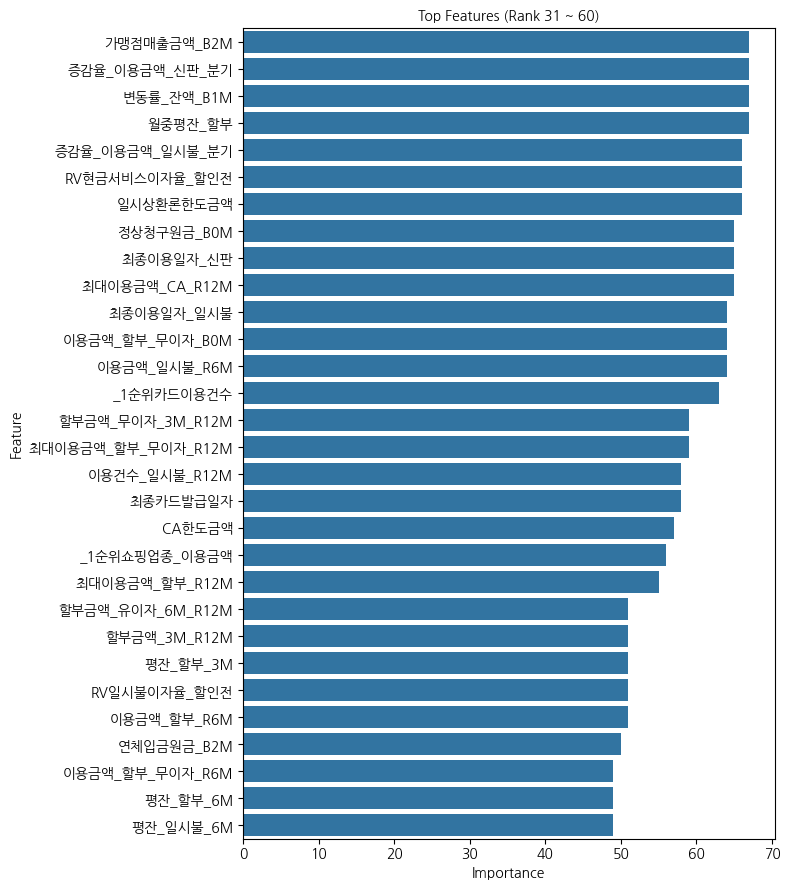

In [8]:
show_next_30_features(model_all, all_columns)  # 31~60


Feature Importance (Rank 61 ~ 90)


,feature,importance
60,증감율_이용금액_신판_전월,48
61,할부금액_무이자_12M_R12M,48
62,할부금액_유이자_14M_R12M,48
63,납부_기타이용금액,47
64,정상입금원금_B0M,47
65,이용금액_오프라인_R3M,47
66,할부금액_12M_R12M,47
67,변동률_잔액_일시불_B1M,47
68,이용건수_일시불_R6M,46
69,최종카드론_대출일자,46


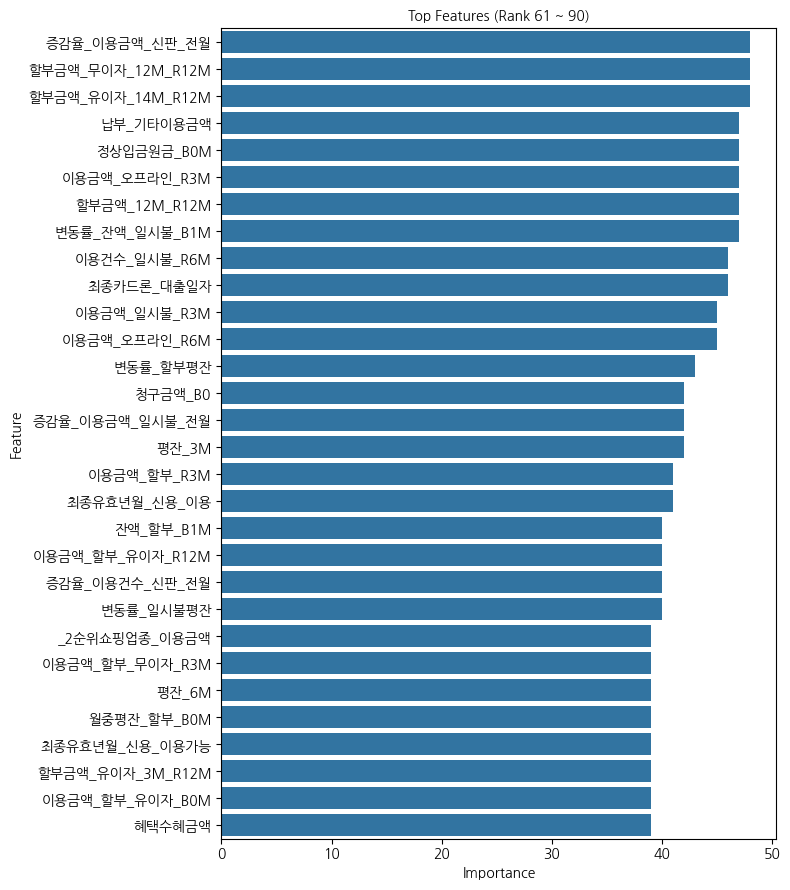

In [9]:
show_next_30_features(model_all, all_columns)  # 61~90